In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

In [2]:
# Load MNIST از فایل محلی
with np.load("../data/mnist.npz") as data:
    x_train_raw, y_train = data["x_train"], data["y_train"]
    x_test_raw, y_test   = data["x_test"], data["y_test"]

print("Train shape:", x_train_raw.shape, x_train_raw.dtype)
print("Test shape:", x_test_raw.shape, x_test_raw.dtype)

# اطمینان از uint8 بودن
x_train_raw = x_train_raw.astype(np.uint8)
x_test_raw  = x_test_raw.astype(np.uint8)

# تغییر شکل برای CNN → (batch, 28, 28, 1)
x_train = x_train_raw.reshape(-1, 28, 28, 1)
x_test  = x_test_raw.reshape(-1, 28, 28, 1)

print("Reshaped Train:", x_train.shape, x_train.dtype)
print("Reshaped Test:", x_test.shape, x_test.dtype)

# ساخت مدل CNN
model = models.Sequential([
    
    layers.Input(shape=(28, 28, 1)),   # ورودی uint8
    
    layers.Rescaling(1./255),          # نرمال‌سازی داخل مدل
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Train shape: (60000, 28, 28) uint8
Test shape: (10000, 28, 28) uint8
Reshaped Train: (60000, 28, 28, 1) uint8
Reshaped Test: (10000, 28, 28, 1) uint8


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(x_test, y_test)
)

# ساخت پوشه models اگر وجود نداشت
os.makedirs("../models", exist_ok=True)

# ذخیره مدل
model.save("../models/CNN.h5")

print("Model saved at ../models/CNN.h5")

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9846 - loss: 0.0508 - val_accuracy: 0.9898 - val_loss: 0.0297
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9888 - loss: 0.0355 - val_accuracy: 0.9843 - val_loss: 0.0529
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9930 - loss: 0.0238 - val_accuracy: 0.9879 - val_loss: 0.0366
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9947 - loss: 0.0169 - val_accuracy: 0.9916 - val_loss: 0.0280
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9956 - loss: 0.0131 - val_accuracy: 0.9911 - val_loss: 0.0290


Model saved at ../models/CNN.h5


In [20]:
# Load trained model
model = tf.keras.models.load_model("../models/CNN.h5")

def predict_image(model ,img, plot=True):
    """
    img: numpy array با shape = (28,28) و dtype=uint8
    """
    
    if img.shape != (28,28):
        raise ValueError("Input image must have shape (28,28)")
    
    if img.dtype != np.uint8:
        raise ValueError("Input dtype must be uint8")
    
    # تبدیل به فرمت مدل
    img_input = img.reshape(1, 28, 28, 1)
    
    prediction = model.predict(img_input)
    predicted_class = np.argmax(prediction)

    if plot == True:
        plt.imshow(img, cmap='gray')
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()
    
    return predicted_class, prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


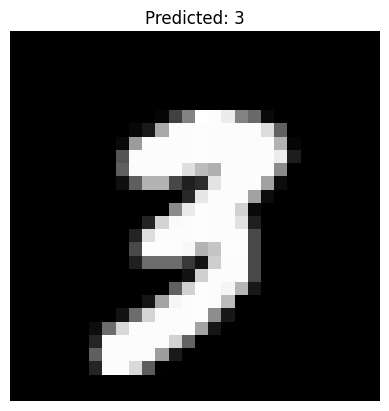

(np.int64(3),
 array([[2.5594945e-13, 1.3135111e-08, 2.0192713e-08, 9.9963284e-01,
         5.5902560e-10, 1.4215141e-06, 1.6432691e-16, 3.4423891e-04,
         1.6408190e-09, 2.1408419e-05]], dtype=float32))

In [22]:
# انتخاب یک تصویر رندوم از test
sample_image = x_train_raw[np.random.randint(0, 60000)].reshape(28, 28)
predict_image(model, sample_image)


حالا میریم سراغ تست با دیتای واقعی که خودمون بهش میدیم

In [14]:
import numpy as np
from PIL import Image

def image_to_mnist(image_path):
    # 1️⃣ Load
    img = Image.open(image_path)
    
    # 2️⃣ Grayscale
    img = img.convert("L")
    
    # 3️⃣ Resize
    img = img.resize((28, 28))
    
    # 4️⃣ To numpy
    img_array = np.array(img).astype(np.float32)
    
    # 5️⃣ Normalize
    img_array /= 255.0
    # 6️⃣ Invert (برای تطبیق با MNIST)
    img_array = 1.0 - img_array
    
    return (img_array * 255).astype('uint8')

 مسیر یک عکس رو بدین تا پیش بینی کنه|

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


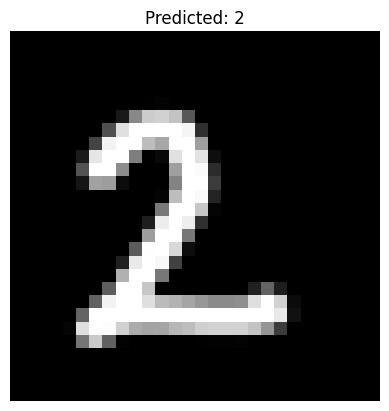

(np.int64(2),
 array([[9.1002967e-08, 4.6863417e-05, 9.9995220e-01, 3.4921033e-10,
         1.1111108e-11, 1.8881426e-11, 2.7010328e-13, 3.4943984e-08,
         8.7274856e-07, 1.8306812e-12]], dtype=float32))

In [23]:
image = image_to_mnist("../image/2.png")
predict_image(model, image)

یا اینکه خودتون عدد رو بنویسید

Press Enter to sava:
image is ready: shape = (28, 28) dtype = uint8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


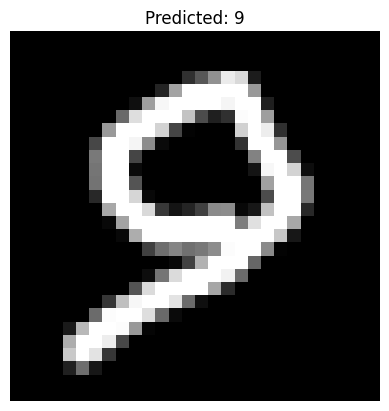

(np.int64(9),
 array([[7.3075030e-09, 1.4777441e-13, 1.9422723e-06, 1.5361701e-07,
         1.8864272e-06, 3.7557589e-07, 4.6576038e-11, 3.3304372e-07,
         4.3702814e-05, 9.9995160e-01]], dtype=float32))

In [38]:
import cv2
import numpy as np

drawing = False
ix, iy = -1, -1

# Canvas بزرگ برای راحتی کاربر
canvas = np.zeros((280, 280), dtype=np.uint8)

# تابع موس
def draw_number(event, x, y, flags, param):
    global ix, iy, drawing, canvas
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            cv2.circle(canvas, (x, y), 12, (255,), -1)
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        cv2.circle(canvas, (x, y), 12, (255,), -1)

cv2.namedWindow('Draw a digit')
cv2.setMouseCallback('Draw a digit', draw_number)

print("Press Enter to sava:")

while True:
    cv2.imshow('Draw a digit', canvas)
    key = cv2.waitKey(1) & 0xFF
    if key == 13:  # Enter
        break

# dilate برای ضخیم‌تر کردن خطوط و جلوگیری از ناپدید شدن pixel
kernel = np.ones((3,3), np.uint8)
canvas_dilated = cv2.dilate(canvas, kernel, iterations=1)

# resize به 28x28 و حفظ uint8
digit_img = cv2.resize(canvas_dilated, (28, 28), interpolation=cv2.INTER_AREA)
digit_img = digit_img.astype(np.uint8)  # خروجی نهایی دقیقاً uint8

cv2.imshow('Digit 28x28', digit_img)
cv2.waitKey(1000)
cv2.destroyAllWindows()

print("image is ready: shape =", digit_img.shape, "dtype =", digit_img.dtype)
predict_image(model, digit_img)
